<a href="https://colab.research.google.com/github/jtw1018/SRCNN_dataset/blob/main/SRCNN_ipynb(20201013).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Super-Resolution Convolutional Neural Network
> In this project, it will show CNN model that can enhance the resolution of image using Convolutional Neural Network. The topic is from the paper "Image Super-Resolution Using Deep Convolutional Networks", presented in ECCV 2014.

- toc: true 
- badges: true
- comments: true
- author: Chanseok Kang
- categories: [Python, Deep_Learning, Vision, Tensorflow-Keras]
- image: images/srcnn_result.png

[Image Super-Resolution Using Deep Convolutional Network](https://arxiv.org/abs/1501.00092) (Dong et al. 2014) introduced the Super-Resolution Convolutional Neural Network (SR-CNN for short) that can enhance the resolution of original image. SR-CNN is deep convolutional neural network that learns end-to-end mapping of low resolution to high resolution image. In this post, we will dig into the basic principles of SR-CNN, and implement it.

In [1]:
!nvidia-smi ## check GPU allocation

Mon Dec  5 04:03:59 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P0    27W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 구글드라이브 마운트

In [2]:
## mount google drive

from google.colab import drive

drive.mount('/content/drive')
%cd /content/drive/MyDrive/VisionAI/SRCNN_4x

Mounted at /content/drive
/content/drive/MyDrive/VisionAI/SRCNN_4x


## Required Packages

In [3]:
import sys, os
import math
import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
import skimage

## Version check

In [4]:
print('Python: {}'.format(sys.version))
print('Numpy: {}'.format(np.__version__))
print('Pandas: {}'.format(pd.__version__))
print('OpenCV: {}'.format(cv2.__version__))
print('Tensorflow: {}'.format(tf.__version__))
print('Matplotlib: {}'.format(mpl.__version__))
print('Scikit-Image: {}'.format(skimage.__version__))

Python: 3.8.15 (default, Oct 12 2022, 19:14:39) 
[GCC 7.5.0]
Numpy: 1.21.6
Pandas: 1.3.5
OpenCV: 4.6.0
Tensorflow: 2.9.2
Matplotlib: 3.2.2
Scikit-Image: 0.18.3


## Metric Functions
사실 우리가 raw 이미지를 보았을 때 이 이미지가 고해상도 이미지인지 아닌지 확인할 수 없습니다.    
이미지 품질을 측정하는 몇 가지 메트릭

- [Peak Signal to Noise Ratio](https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio) (PSNR)
- Mean Squared Error (MSE)
- [Structural Similarity](https://en.wikipedia.org/wiki/Structural_similarity) (SSIM)

### Peak Signal-to-Noise Ratio (PSNR)


In [5]:
def psnr(target, ref):
    # Assume target is RGB/BGR image
    target_data = target.astype(np.float32)
    ref_data = ref.astype(np.float32)
    
    diff = ref_data - target_data
    diff = diff.flatten('C')
    
    rmse = np.sqrt(np.mean(diff ** 2.))
    
    return 20 * np.log10(255. / rmse)

### Mean Squared Error (MSE)

In [6]:
def mse(target, ref):
    target_data = target.astype(np.float32)
    ref_data = ref.astype(np.float32)
    err = np.sum((target_data - ref_data) ** 2)
    
    err /= np.float(target_data.shape[0] * target_data.shape[1])
    return err

### 구조적 유사성
실제로 이 메트릭은 이미 skimage에 구현되어 있습니다.

In [7]:
from skimage.metrics import structural_similarity as ssim

이미지 품질을 측정하기 위한 메트릭을 정의한 후에는 전체 메트릭을 하나의 메트릭으로 결합해야 합니다.

In [8]:
def compare_images(target, ref):
    scores = []
    scores.append(psnr(target, ref))
    scores.append(mse(target, ref))
    scores.append(ssim(target, ref, multichannel=True))
    return scores

## Prepare distorted images via resizing
원시 데이터에서 어떻게 왜곡된 이미지를 만들 수 있습니까? 간단합니다. 원본 이미지를 축소한 후 이전 너비 높이로 다시 크기를 조정하면 크기 조정 중에 픽셀 정보가 손실될 수 있으므로 해상도가 낮아집니다.

In [9]:
def prepare_images(path, factor):
    # Loop through the files in the directory
    for file in os.listdir(path):
        image = cv2.imread(path + '/' + file)
        
        # Find old and new image dimensions
        h, w, c = image.shape
        new_height = int(h / factor)
        new_width = int(w / factor)
        
        # Resize down the image
        image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_LINEAR)
        
        # Resize up the image
        image = cv2.resize(image, (w, h), interpolation=cv2.INTER_LINEAR)
        
        # Save the image
        try:
            os.listdir(path + '/../../resized')
        except:
            os.mkdir(path + '/../../resized')
            
        cv2.imwrite(path + '/../../resized/{}'.format(file), image)

In [10]:
prepare_images('./Test/Set5', 4)

Let's see it works.

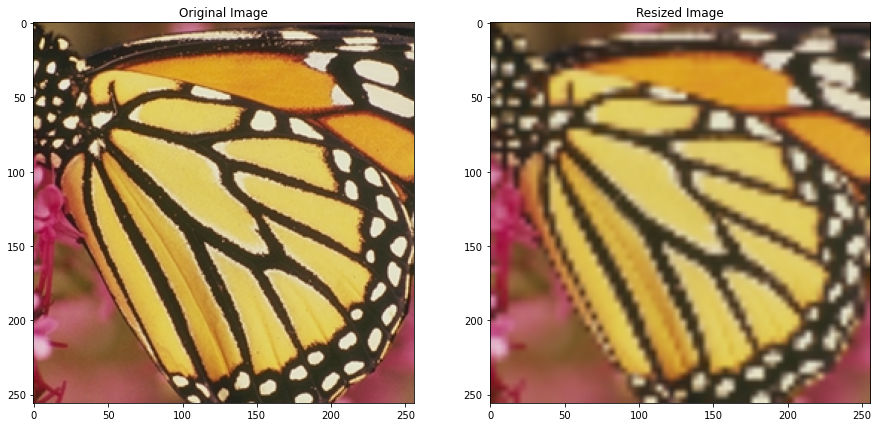

In [11]:
from PIL import Image
fig, ax = plt.subplots(1, 2, figsize=(15, 10))
ax[0].imshow(Image.open('./Test/Set5/butterfly_GT.bmp'))
ax[0].title.set_text('Original Image')
ax[1].imshow(Image.open('./resized/butterfly_GT.bmp'))
ax[1].title.set_text('Resized Image')
plt.show()

왼쪽 이미지에 비해 오른쪽 이미지가 약간 흐릿한 것을 볼 수 있습니다. 확인할 수 없으면 이전에 정의한 메트릭 함수를 사용하십시오.

In [12]:
target = cv2.imread('./Test/Set5/butterfly_GT.bmp')
ref = cv2.imread('./resized/butterfly_GT.bmp')

metrics = compare_images(target, ref)
print("PSNR: {}".format(metrics[0]))
print("MSE: {}".format(metrics[1]))
print("SSIM: {}".format(metrics[2]))

PSNR: 20.21670142260436
MSE: 1855.80126953125
SSIM: 0.7163310820830953


<ipython-input-6-dffab844877c>:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  err /= np.float(target_data.shape[0] * target_data.shape[1])


## Data Augmentation

실제로 임의 자르기와 같은 데이터 증대를 위한 여러 가지 변환이 있습니다. [누군가](https://github.com/MarkPrecursor/SRCNN-keras/blob/master/prepare_data.py)는 스크립트를 통해 h5 형식의 데이터 세트를 만들었으므로 거기에서 차용합니다.

In [14]:
# ref - https://github.com/MarkPrecursor/SRCNN-keras/blob/master/prepare_data.py
# Build train dataset
import h5py

names = sorted(os.listdir('./Train'))

data = []
label = []

for name in names:
    fpath = './Train/' + name
    hr_img = cv2.imread(fpath, cv2.IMREAD_COLOR)
    hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2YCrCb)
    hr_img = hr_img[:, :, 0]
    shape = hr_img.shape
    
    # resize operation to produce training data and labels
    lr_img = cv2.resize(hr_img, (int(shape[1] / 4), int(shape[0] / 4)))
    lr_img = cv2.resize(lr_img, (shape[1], shape[0]))
    
    width_range = int((shape[0] - 16 * 2) / 16)
    height_range = int((shape[1] - 16 * 2) / 16)
    
    for k in range(width_range):
        for j in range(height_range):
            x = k * 16
            y = j * 16
            
            hr_patch = hr_img[x: x + 32, y: y + 32]
            lr_patch = lr_img[x: x + 32, y: y + 32]
            
            hr_patch = hr_patch.astype(np.float32) / 255.
            lr_patch = lr_patch.astype(np.float32) / 255.
            
            hr = np.zeros((1, 20, 20), dtype=np.double)
            lr = np.zeros((1, 32, 32), dtype=np.double)
            
            hr[0, :, :] = hr_patch[6:-6, 6: -6]
            lr[0, :, :] = lr_patch
            
            label.append(hr)
            data.append(lr)

data = np.array(data, dtype=np.float32)
label = np.array(label, dtype=np.float32)

In [15]:
with h5py.File('train.h5', 'w') as h:
    h.create_dataset('data', data=data, shape=data.shape)
    h.create_dataset('label', data=label, shape=label.shape)

In [16]:
# ref - https://github.com/MarkPrecursor/SRCNN-keras/blob/master/prepare_data.py
# Build test dataset

names = sorted(os.listdir('./Test/Set5'))
nums = len(names)

data_test = np.zeros((nums * 30, 1, 32, 32), dtype=np.double)
label_test = np.zeros((nums * 30, 1, 20, 20), dtype=np.double)

for i, name in enumerate(names):
    fpath = './Test/Set5/' + name
    hr_img = cv2.imread(fpath, cv2.IMREAD_COLOR)
    hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2YCrCb)
    hr_img = hr_img[:, :, 0]
    shape = hr_img.shape
    
    # resize operation to produce training data and labels
    lr_img = cv2.resize(hr_img, (int(shape[1] / 4), int(shape[0] / 4)))
    lr_img = cv2.resize(lr_img, (shape[1], shape[0]))
    
    # Produce random crop
    x = np.random.randint(0, min(shape[0], shape[1]) - 32, 30)
    y = np.random.randint(0, min(shape[0], shape[1]) - 32, 30)
    
    for j in range(30):
        lr_patch = lr_img[x[j]:x[j] + 32, y[j]:y[j] + 32]
        hr_patch = hr_img[x[j]:x[j] + 32, y[j]:y[j] + 32]
        
        lr_patch = lr_patch.astype(np.float32) / 255.
        hr_patch = hr_patch.astype(np.float32) / 255.
        
        data_test[i * 30 + j, 0, :, :] = lr_patch
        label_test[i * 30 + j, 0, :, :] = hr_patch[6: -6, 6: -6]

In [17]:
with h5py.File('test.h5', 'w') as h:
    h.create_dataset('data', data=data_test, shape=data_test.shape)
    h.create_dataset('label', data=label_test, shape=label_test.shape)

## Build SR-CNN Model
데이터 세트를 h5 형식으로 준비했습니다. 또한 tensorflow를 사용하여 SR-CNN 모델을 구축해야 합니다. Keras 프레임워크가 tensorflow v2.x에 통합되어 있다는 것을 이미 알고 있습니다. 따라서 tensorflow-keras 모델로 구현할 수 있습니다. 이 경우 순차 모델로 빌드합니다.

In [18]:
# Define the SR-CNN model
def model():
    SRCNN = tf.keras.Sequential(name='SRCNN')
    SRCNN.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(9, 9), 
                                     padding='VALID',
                                     use_bias=True,
                                     input_shape=(None, None, 1),
                                     kernel_initializer='glorot_uniform',
                                     activation='relu'))
    SRCNN.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3),
                                     padding='SAME',
                                     use_bias=True,
                                     kernel_initializer='glorot_uniform',
                                     activation='relu'))
    SRCNN.add(tf.keras.layers.Conv2D(filters=1, kernel_size=(5, 5),
                                     padding='VALID',
                                     use_bias=True,
                                     kernel_initializer='glorot_uniform',
                                     activation='linear'))
    # Optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0003)
    
    # Compile model
    SRCNN.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error'])
    
    return SRCNN

## Train the model
이제 모델을 학습시킬 차례입니다. 우리 모델은 어떻게 생겼습니까?

In [19]:
srcnn_model = model()
srcnn_model.summary()

Model: "SRCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, None, None, 128)   10496     
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 64)    73792     
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 1)     1601      
                                                                 
Total params: 85,889
Trainable params: 85,889
Non-trainable params: 0
_________________________________________________________________


미리 빌드된 h5 파일에서 데이터 세트를 로드합니다. 체크포인트를 정의하는데 도움이 될 것입니다.

In [20]:
with h5py.File('./train.h5', 'r') as h:
    data = np.array(h.get('data'))
    label = np.array(h.get('label'))
    X_train = np.transpose(data, (0, 2, 3, 1))
    y_train = np.transpose(label, (0, 2, 3, 1))
    
with h5py.File('./test.h5', 'r') as h:
    data = np.array(h.get('data'))
    label = np.array(h.get('label'))
    X_test = np.transpose(data, (0, 2, 3, 1))
    y_test = np.transpose(label, (0, 2, 3, 1))
    
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((14901, 32, 32, 1), (14901, 20, 20, 1), (150, 32, 32, 1), (150, 20, 20, 1))

In [21]:
checkpoint_path = './srcnn/cp-{epoch:04d}.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_dir, save_best_only=True,
                                                 save_weights_only=True, verbose=0)

In [22]:
srcnn_model.fit(X_train, y_train, batch_size=64, validation_data=(X_test, y_test), 
                callbacks=[checkpoint], shuffle=True, epochs=200, verbose=True)

Epoch 1/200
233/233 [==============================] - 12s 13ms/step - loss: 0.0081 - mean_squared_error: 0.0081 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 2/200
233/233 [==============================] - 2s 8ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 3/200
233/233 [==============================] - 2s 8ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 4/200
233/233 [==============================] - 2s 8ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 5/200
233/233 [==============================] - 2s 8ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 6/200
233/233 [==============================] - 2s 8ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 7/200
233/233 

Finally, Training is done. 

# Predict image from model

## 초해상화 4x

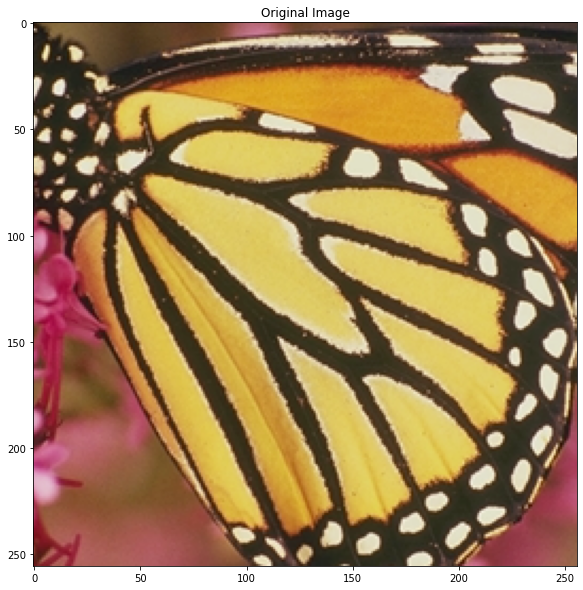

In [23]:
fig, ax = plt.subplots(figsize=(15, 10))
ax.imshow(Image.open('./Test/Set5/butterfly_GT.bmp'))
ax.title.set_text("Original Image")
plt.show()

Then we need to make distorted image by resizing down and up.

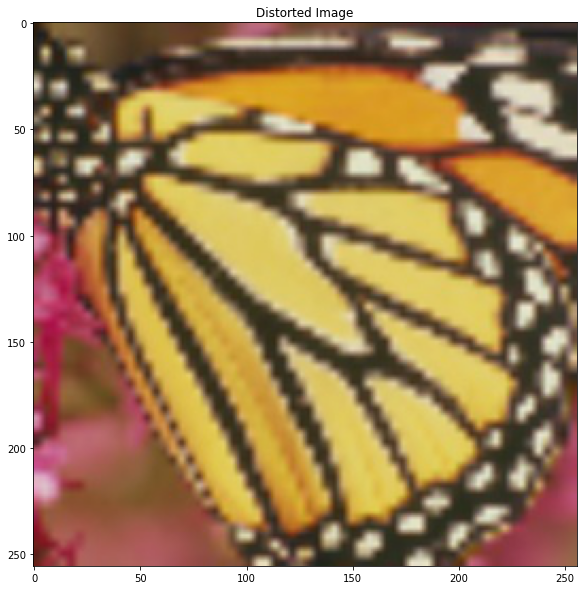

In [24]:
# Make output directory
try:
    os.listdir('./output')
except:
    os.mkdir('./output')

target = cv2.imread('./Test/Set5/butterfly_GT.bmp', cv2.IMREAD_COLOR)
target = cv2.cvtColor(target, cv2.COLOR_BGR2YCrCb)
shape = target.shape

# Resize down by scale of 4
Y_img = cv2.resize(target[:, :, 0], (int(shape[1] / 4), int(shape[0] / 4)), cv2.INTER_CUBIC)

# Resize up to orignal image
Y_img = cv2.resize(Y_img, (shape[1], shape[0]), cv2.INTER_CUBIC)
target[:, :, 0] = Y_img
target = cv2.cvtColor(target, cv2.COLOR_YCrCb2BGR)
cv2.imwrite('./output/butterfly_bicubic_scale_4.jpg', target)

fig, ax = plt.subplots(figsize=(15, 10))
ax.imshow(Image.open('./output/butterfly_bicubic_scale_4.jpg'))
ax.title.set_text("Distorted Image")
plt.show()

1/1 [==============================] - 0s 349ms/step


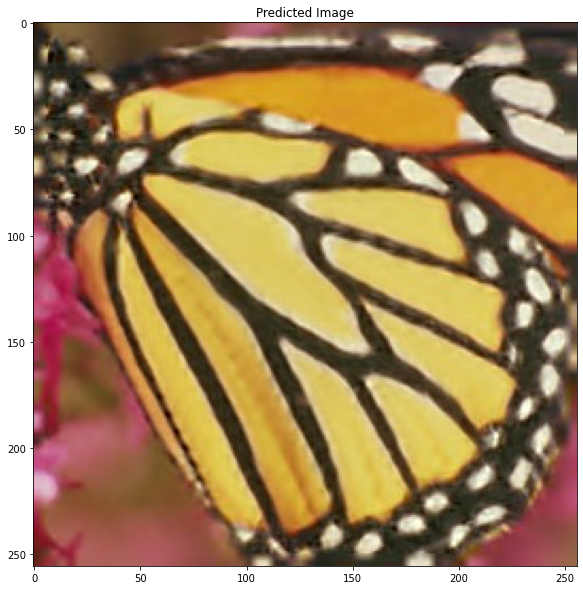

In [25]:
Y = np.zeros((1, target.shape[0], target.shape[1], 1), dtype=np.float32)
# Normalize
Y[0, :, :, 0] = Y_img.astype(np.float32) / 255.

# Predict
pre = srcnn_model.predict(Y, batch_size=1) * 255.

# Post process output
pre[pre[:] > 255] = 255
pre[pre[:] < 0] = 0
pre = pre.astype(np.uint8)

# Copy y channel back to image and convert to BGR
output = cv2.cvtColor(target, cv2.COLOR_BGR2YCrCb)
output[6: -6, 6: -6, 0] = pre[0, :, :, 0]
output = cv2.cvtColor(output, cv2.COLOR_YCrCb2BGR)

# Save image
cv2.imwrite('./output/butterfly_Predicted_scale_4.jpg', output)

fig, ax = plt.subplots(figsize=(15, 10))
ax.imshow(Image.open('./output/butterfly_Predicted_scale_4.jpg'))
ax.title.set_text("Predicted Image")
plt.show()

We can compare those images simultaneously.

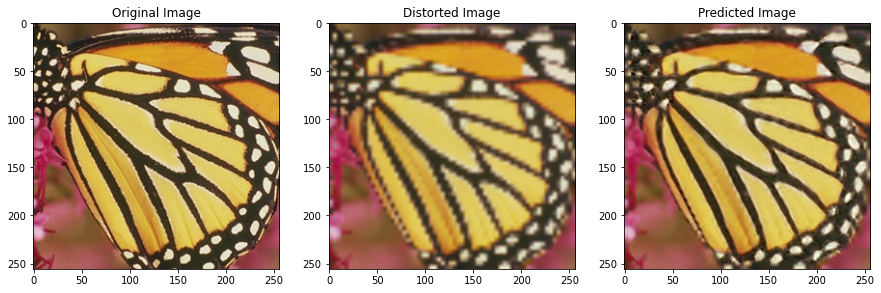

In [26]:
fig, ax = plt.subplots(1, 3, figsize=(15, 10))
ax[0].imshow(Image.open('./Test/Set5/butterfly_GT.bmp'))
ax[0].title.set_text("Original Image")

ax[1].imshow(Image.open('./output/butterfly_bicubic_scale_4.jpg'))
ax[1].title.set_text("Distorted Image")

ax[2].imshow(Image.open('./output/butterfly_Predicted_scale_4.jpg'))
ax[2].title.set_text("Predicted Image")

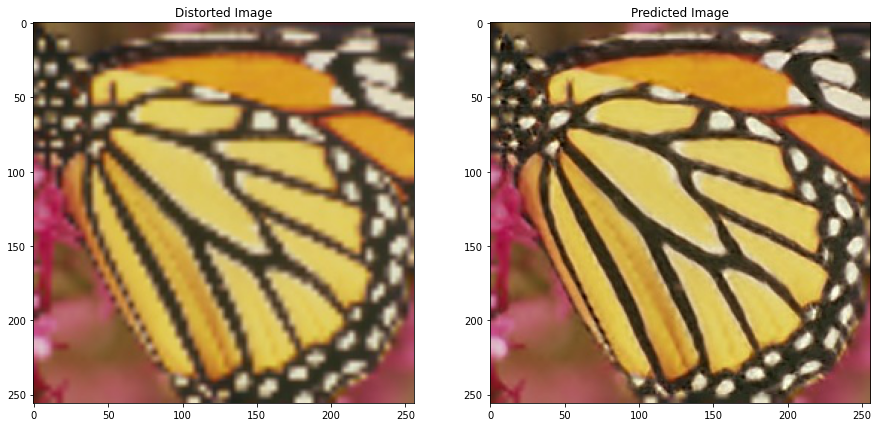

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(15, 10))
ax[0].imshow(Image.open('./output/butterfly_bicubic_scale_4.jpg'))
ax[0].title.set_text("Distorted Image")

ax[1].imshow(Image.open('./output/butterfly_Predicted_scale_4.jpg'))
ax[1].title.set_text("Predicted Image")

Here, we can use PSNR and SSIM metrics for comparison. Of course, we need to compare each images with original image.

In [28]:
original = cv2.imread('./Test/Set5/butterfly_GT.bmp')
distorted = cv2.imread('./output/butterfly_bicubic_scale_4.jpg')
predicted = cv2.imread('./output/butterfly_Predicted_scale_4.jpg')

#### 원본과 왜곡(4x) 이미지 비교 (평가식)

In [29]:
metrics = compare_images(original, distorted)
print("Metrics for original and distorted image")
print("PSNR: {}".format(metrics[0]))
print("MSE: {}".format(metrics[1]))
print("SSIM: {}".format(metrics[2]))

Metrics for original and distorted image
PSNR: 20.157642430191032
MSE: 1881.21044921875
SSIM: 0.7026211191647667


<ipython-input-6-dffab844877c>:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  err /= np.float(target_data.shape[0] * target_data.shape[1])


#### 원본과 초해상화(4x) 이미지 비교 (평가식)

In [30]:
metrics = compare_images(original, predicted)
print("Metrics for original and predicted image")
print("PSNR: {}".format(metrics[0]))
print("MSE: {}".format(metrics[1]))
print("SSIM: {}".format(metrics[2]))

Metrics for original and predicted image
PSNR: 21.64181017898852
MSE: 1336.6590576171875
SSIM: 0.7915640943715033


<ipython-input-6-dffab844877c>:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  err /= np.float(target_data.shape[0] * target_data.shape[1])


### SRCNN 은 최초의 초해상화 인공신경망 모델로 2배 확대 이미지는 우수하나 그 이상의 이미지 확대시 성과 향상이 미미하다는 것을 알수 있음